In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Dataset Used:
- Project Gutenberg eBook of [The Brothers Karamazov](https://www.gutenberg.org/ebooks/28054)

# Overview
- Find any book with ~10,000 sentences.
- Do the traditional steps and find the number of points in each clusters.
- Normalize the vector by dividing it with the maximum value.
- Now cluster the clusters. Perform a histogram on the normalized vector.
- Bin the x axis into 20 or 30 equally spaced bins. For example, 0.05, 0.1, 0.15.. till 1.
- Find the number of indices of this vector which falls under each bins.
- Save the (number of clusters) count in a vector.
- Rearrange them, and plot the count in y-axis and bins in the x-axis.
- Plot the log log plot using the count matrix.
- Fit the log log plot with linear line and get the slope.

# Data Preprocessing
- Boilerplate stripped, whitespace normalized, chapter headers removed
- Total sentences: 19,561
• Middle 10,000 sentences extracted for analysis

In [2]:
import re
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt_tab')

with open('/content/drive/MyDrive/Colab Notebooks/the_brothers_karamazov.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

def strip_gutenberg_boilerplate(text):
    start = r'\*\*\* START OF (THE|THIS) PROJECT GUTENBERG EBOOK .* \*\*\*'
    end = r'\*\*\* END OF (THE|THIS) PROJECT GUTENBERG EBOOK .* \*\*\*'
    text = re.split(start, text, maxsplit=1, flags=re.IGNORECASE)[-1]
    text = re.split(end, text, maxsplit=1, flags=re.IGNORECASE)[0]
    return text.strip()

clean_text = strip_gutenberg_boilerplate(raw_text)

clean_text = re.sub(r'\s+', ' ', clean_text)
clean_text = re.sub(r'[_*"#]', '', clean_text)


clean_text = re.sub(r'Chapter\s+[IVXLCDM]+\.\s+.*?(?=\s[A-Z])', '', clean_text)

sentences = sent_tokenize(clean_text)

print(f"Number of sentences: {len(sentences)}")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Number of sentences: 19561


In [3]:
# get middle 10,000 sentences
total = len(sentences)
middle_start = max((total // 2) - 5000, 0)
middle_end = min((total // 2) + 5000, total)

middle_sentences = sentences[middle_start:middle_end]

print(f"Extracted {len(middle_sentences)} middle sentences (from {middle_start} to {middle_end})")

print(middle_sentences)

Extracted 10000 middle sentences (from 4780 to 14780)
['“What do I know about love and women and how can I decide such questions?” he thought reproachfully, after such doubts and surmises.', 'And yet it was impossible not to think about it.', 'He felt instinctively that this rivalry was of immense importance in his brothers’ lives and that a great deal depended upon it.', '“One reptile will devour the other,” Ivan had pronounced the day before, speaking in anger of his father and Dmitri.', 'So Ivan looked upon Dmitri as a reptile, and perhaps had long done so.', 'Was it perhaps since he had known Katerina Ivanovna?', 'That phrase had, of course, escaped Ivan unawares yesterday, but that only made it more important.', 'If he felt like that, what chance was there of peace?', 'Were there not, on the contrary, new grounds for hatred and hostility in their family?', 'And with which of them was Alyosha to sympathize?', 'And what was he to wish for each of them?', 'He loved them both, but wha

In [4]:
import json

out_path = "/content/karamazov_10000_sentences.json"

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(middle_sentences, f, ensure_ascii=False, indent=4)

print(f"Saved {len(middle_sentences)} sentences → {out_path}")

Saved 10000 sentences → /content/karamazov_10000_sentences.json


# Load Model: all-mpnet-base-v2

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(middle_sentences, normalize_embeddings=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# K-means with kneed

In [13]:
pip install scikit-learn kneed

In [ ]:
from sklearn.preprocessing import normalize
norm_embeddings = normalize(embeddings, norm='l2')

In [15]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from kneed import KneeLocator

def find_optimal_k(embeddings, k_samples=None, k_min=5, k_max=50, k_step=None, random_sampling=False, plot=True):
    # random sampling or sequential?
    if random_sampling:
        random.seed(42)
        K = sorted(random.sample(range(k_min, k_max + 1), k_samples))
    else:
        K = list(range(k_min, k_max + 1, k_step if k_step else 1))

    # calculate WCSS for each k value
    wcss = []
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    # find the knee point using KneeLocator
    knee = KneeLocator(K, wcss, curve='convex', direction='decreasing')
    optimal_k = knee.knee

    # plot the results if plot=True
    print("plotting")
    if plot and optimal_k:
        plt.figure(figsize=(8, 5))
        plt.plot(K, wcss, 'bo-', label='WCSS')
        plt.axvline(optimal_k, color='red', linestyle='--', label=f'Knee at k={optimal_k}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('WCSS (Inertia)')
        plt.title('Elbow Method for Optimal k')
        plt.legend()
        plt.grid(True)
        plt.show()

    return optimal_k

plotting


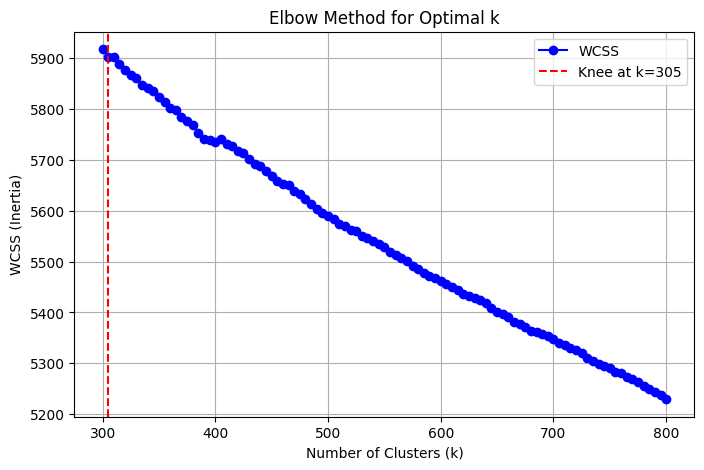

In [ ]:
optimal_k = find_optimal_k(norm_embeddings, k_min=300, k_max=800, k_step=5)

In [ ]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(embeddings)

print(f"KMeans completed with k = {optimal_k}")

KMeans completed with k = 305


In [ ]:
#find the number of points in each clusters. store it into a vector.
from collections import Counter

cluster_counts = Counter(labels)

counts = np.array(list(cluster_counts.values()))


sorted_counts_desc = np.sort(counts)[::-1]

print("sentence counts sorted: ", sorted_counts_desc)

# Normalize the vector by dividing it with the maximum value.
normalized_counts = sorted_counts_desc / np.max(sorted_counts_desc)

print("normalized counts: ", normalized_counts)

sentence counts sorted:  [98 82 76 76 75 74 73 72 71 69 67 67 66 66 61 60 60 59 57 57 56 56 55 54
 54 53 53 53 52 52 52 51 50 50 50 50 49 48 47 47 47 47 46 46 46 45 45 44
 44 44 44 44 43 43 43 43 42 42 42 41 41 41 41 41 41 41 40 40 40 40 40 40
 40 40 40 39 39 39 39 39 39 39 39 38 38 38 38 38 38 37 37 37 37 37 37 37
 37 37 37 37 37 37 37 36 36 36 36 36 36 36 36 36 35 35 35 35 35 35 35 35
 35 35 34 34 34 34 34 34 34 33 33 33 33 33 33 32 32 32 32 32 32 32 32 32
 32 32 31 31 31 31 31 31 31 31 30 30 30 30 30 30 30 30 30 30 29 29 29 29
 29 29 29 29 29 29 28 28 28 28 28 28 28 28 28 28 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 26 26 26 26 25 25 25 25 25 25 25 25 25 25
 25 25 24 24 24 24 24 24 24 24 24 23 23 23 23 23 23 23 23 23 23 22 22 22
 22 22 22 22 22 21 21 20 20 20 19 19 19 19 19 19 19 19 19 19 18 18 18 18
 18 18 17 17 17 17 17 16 16 16 16 16 16 16 16 16 15 15 15 15 15 15 15 14
 14 14 14 14 13 13 13 13 12 12 11 11 11 10  9  7  6]
normalized counts:  [1.         0.83673469 0.7

In [ ]:
# Get cluster IDs w exactlly
target_size = 36
target_clusters = [cluster_id for cluster_id, count in cluster_counts.items() if count == target_size]

# Print all sentences belonging to those clusters
for target_cluster in target_clusters:
    print(f"\nSentences in Cluster ID: {target_cluster} (size = {target_size})\n")
    for i, label in enumerate(labels):
      if label == target_cluster:
          print(f"• {middle_sentences[i]}")


Sentences in Cluster ID: 199 (size = 36)

• That phrase had, of course, escaped Ivan unawares yesterday, but that only made it more important.
• He knows it.” “Yes, I approve of it,” Ivan assented, in a subdued but firm voice.
• Ivan Fyodorovitch fully approves me.” She was breathless.
• “Call Dmitri; I will fetch him—and let him come here and take your hand and take Ivan’s and join your hands.
• Ivan suddenly laughed and got up.
• “Come back, Ivan!
• Dmitri says of you—Ivan is a tomb!
• I say of you, Ivan is a riddle.
• “I understand too well, Ivan.
• Half your work is done, Ivan, you love life, now you’ve only to try to do the second half and you are saved.” “You are trying to save me, but perhaps I am not lost!
• I am so glad of our talk, Ivan.” “I see you are feeling inspired.
• I could never have guessed even yesterday, how easy it would be to put an end to it if I wanted.” “You are speaking of your love, Ivan?” “Of my love, if you like.
• We’ve plenty of time before I go, an ete

# Histogram:

Bins: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
Counts per bin: [ 0  3 15 37 32 54 42 47 28 10 12  7  4  4  4  4  1  0  0  1]


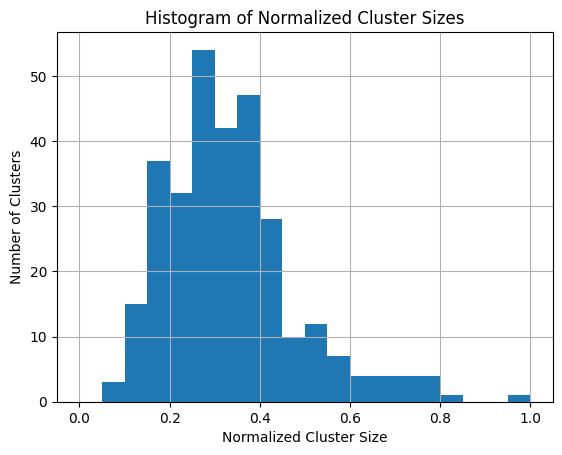

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 20 equally spaced bins between 0 and 1
bins = np.linspace(0, 1, 21)

# Histogram: counts how many cluster sizes fall into each bin
hist, bin_edges = np.histogram(normalized_counts, bins=bins)

# Save the counts vector
cluster_bin_counts = hist

print("Bins:", bin_edges)
print("Counts per bin:", cluster_bin_counts)

plt.bar(bin_edges[:-1], cluster_bin_counts, width=0.05, align='edge')
plt.xlabel('Normalized Cluster Size')
plt.ylabel('Number of Clusters')
plt.title('Histogram of Normalized Cluster Sizes')
plt.grid(True)
plt.show()


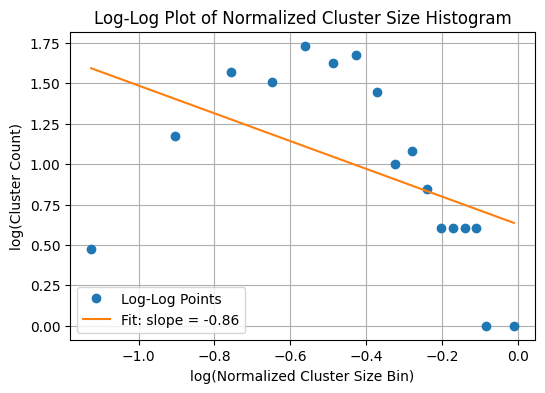

Slope of log-log fit: -0.8590


In [ ]:
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
counts_y = cluster_bin_counts

# Filter out zero counts to avoid log(0)
nonzero_mask = counts_y > 0
x_vals = bin_centers[nonzero_mask]
y_vals = counts_y[nonzero_mask]

#Convert to log-log scale
log_x = np.log10(x_vals)
log_y = np.log10(y_vals)

# Fit a linear regression line
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

# Plot log-log with linear fit
plt.figure(figsize=(6, 4))
plt.plot(log_x, log_y, 'o', label='Log-Log Points')
plt.plot(log_x, slope * log_x + intercept, label=f'Fit: slope = {slope:.2f}')
plt.xlabel('log(Normalized Cluster Size Bin)')
plt.ylabel('log(Cluster Count)')
plt.title('Log-Log Plot of Normalized Cluster Size Histogram')
plt.legend()
plt.grid(True)
plt.show()

# Print slope value
print(f"Slope of log-log fit: {slope:.4f}")


# Sentence Count distribution plot & Log Log plot


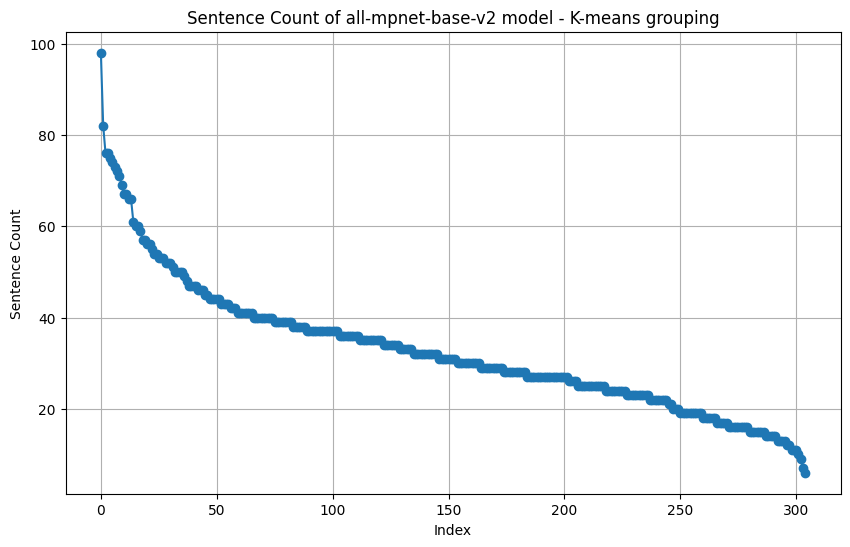

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Plot sentence count distribution
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_counts_desc)), sorted_counts_desc, marker='o')
plt.title("Sentence Count of all-mpnet-base-v2 model - K-means grouping")
plt.xlabel('Index')
plt.ylabel('Sentence Count')
plt.grid(True)
plt.show()



Regression Results:
   - Slope: -0.4040
   - Intercept: 2.3054
   - R-squared: 0.7731
   - P-value: 1.3059e-99


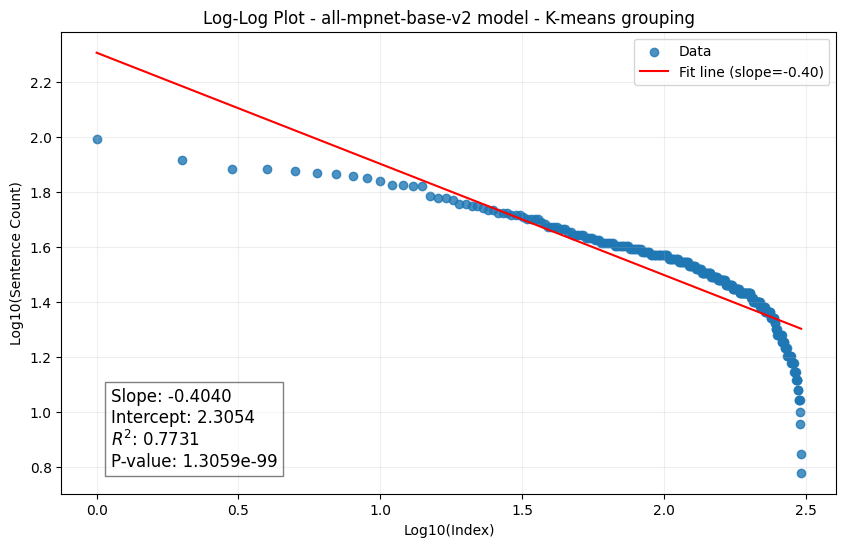

In [ ]:
# Linear regression function
def linear_regression(counts):
    x = np.log10(np.arange(1, len(counts)+1))
    y = np.log10(counts)
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    y_pred = slope * x + intercept
    return x, y, slope, intercept, r_val, p_val, y_pred

# Apply regression
x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(sorted_counts_desc)

# Plot regression line on log-log data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.8, label='Data')
plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')
plt.title("Log-Log Plot - all-mpnet-base-v2 model - K-means grouping")
plt.xlabel('Log10(Index)')
plt.ylabel('Log10(Sentence Count)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

# Annotate stats
text_x = min(x) + (max(x) - min(x)) * 0.02
text_y = min(y) + (max(y) - min(y)) * 0.02
plt.text(text_x, text_y,
         f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Print to console
print("\nRegression Results:")
print(f"   - Slope: {slope:.4f}")
print(f"   - Intercept: {intercept:.4f}")
print(f"   - R-squared: {r_val**2:.4f}")
print(f"   - P-value: {p_val:.4e}")

plt.show()

# Clustering based on next token (GPT2)
- Extract the final layer in LLM which performs the softmax. (MLP or Fully connected NN)
- Now perform classification to predict the next word for a given input vector.
- Now count the number of these points inside each cluster and do the similar statistics. (Both old and New)

In [5]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("sshleifer/tiny-gpt2")
model = GPT2LMHeadModel.from_pretrained("sshleifer/tiny-gpt2", output_hidden_states=True)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [7]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from tqdm import tqdm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from tqdm import tqdm

# load GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token for batching
model = GPT2LMHeadModel.from_pretrained("gpt2", output_hidden_states=True).cuda()
model.eval()

hidden_vectors = []
next_token_ids = []

batch_size = 32
for i in tqdm(range(0, len(middle_sentences), batch_size), desc="Processing batches"):
    batch = middle_sentences[i:i+batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")

    with torch.no_grad():
        outputs = model(**inputs)

    # get hidden states and logits for the last token of each sequence (after padding)
    last_hidden_states = outputs.hidden_states[-1]
    logits = outputs.logits

    # use attention mask to get actual last token positions
    last_token_indices = inputs["attention_mask"].sum(dim=1) - 1

    for j in range(len(batch)):
        last_index = last_token_indices[j]
        last_hidden = last_hidden_states[j, last_index, :]
        hidden_vectors.append(last_hidden.cpu().numpy())

        pred_token_id = torch.argmax(logits[j, last_index, :]).item()
        next_token_ids.append(pred_token_id)


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Processing batches: 100%|██████████| 313/313 [00:19<00:00, 16.29it/s]


In [8]:
from collections import defaultdict
import numpy as np

# dictionary to group vectors by their predicted next_token_id
clusters_by_token = defaultdict(list)
sentence_groups = defaultdict(list)

# group the hidden vectors and sentences
for vector, token_id, sentence in zip(hidden_vectors, next_token_ids, middle_sentences):
    clusters_by_token[token_id].append(vector)
    sentence_groups[token_id].append(sentence)

for token_id in clusters_by_token:
    clusters_by_token[token_id] = np.stack(clusters_by_token[token_id])

print(f"Total unique predicted tokens: {len(clusters_by_token)}")
for token_id, vectors in clusters_by_token.items():
    token_str = tokenizer.decode([token_id])  # decode token ID to string
    print(f"Token ID {token_id} ('{token_str}') → {vectors.shape[0]} vectors")

print("\nUnique predicted token strings:")
unique_tokens_sorted = sorted(clusters_by_token.keys())
print([tokenizer.decode([tid]) for tid in unique_tokens_sorted])



Total unique predicted tokens: 52
Token ID 447 ('�') → 1412 vectors
Token ID 198 ('
') → 5748 vectors
Token ID 679 (' He') → 635 vectors
Token ID 37653 (' Reload') → 1 vectors
Token ID 314 (' I') → 1119 vectors
Token ID 366 (' "') → 291 vectors
Token ID 564 (' �') → 265 vectors
Token ID 1 ('"') → 46 vectors
Token ID 326 (' that') → 3 vectors
Token ID 843 (' And') → 21 vectors
Token ID 1375 (' She') → 105 vectors
Token ID 887 (' But') → 37 vectors
Token ID 921 (' You') → 28 vectors
Token ID 357 (' (') → 2 vectors
Token ID 775 (' We') → 36 vectors
Token ID 383 (' The') → 117 vectors
Token ID 1550 (' On') → 2 vectors
Token ID 1119 (' They') → 31 vectors
Token ID 960 ('—') → 12 vectors
Token ID 318 (' is') → 2 vectors
Token ID 290 (' and') → 7 vectors
Token ID 4362 (' Because') → 5 vectors
Token ID 632 (' It') → 21 vectors
Token ID 5660 (' Run') → 1 vectors
Token ID 34048 (' Thou') → 1 vectors
Token ID 3244 (' Then') → 2 vectors
Token ID 40 ('I') → 16 vectors
Token ID 1114 (' For') → 1 vec

In [ ]:
# get cluster sizes
cluster_counts = {token_id: vectors.shape[0] for token_id, vectors in clusters_by_token.items()}

# get only the counts (number of points per cluster)
counts = np.array(list(cluster_counts.values()))

# sort in descending order
sorted_counts_desc = np.sort(counts)[::-1]
print("Sentence counts sorted:", sorted_counts_desc)

# normalize by the max value
normalized_counts = sorted_counts_desc / np.max(sorted_counts_desc)
print("Normalized counts:", normalized_counts)


Sentence counts sorted: [5748 1412 1119  635  291  265  117  105   46   37   36   31   28   21
   21   16   12    7    5    3    3    3    2    2    2    2    2    2
    2    2    2    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1]
Normalized counts: [1.00000000e+00 2.45650661e-01 1.94676409e-01 1.10473208e-01
 5.06263048e-02 4.61029923e-02 2.03549061e-02 1.82672234e-02
 8.00278358e-03 6.43702157e-03 6.26304802e-03 5.39318024e-03
 4.87125957e-03 3.65344468e-03 3.65344468e-03 2.78357690e-03
 2.08768267e-03 1.21781489e-03 8.69867780e-04 5.21920668e-04
 5.21920668e-04 5.21920668e-04 3.47947112e-04 3.47947112e-04
 3.47947112e-04 3.47947112e-04 3.47947112e-04 3.47947112e-04
 3.47947112e-04 3.47947112e-04 3.47947112e-04 1.73973556e-04
 1.73973556e-04 1.73973556e-04 1.73973556e-04 1.73973556e-04
 1.73973556e-04 1.73973556e-04 1.73973556e-04 1.73973556e-04
 1.73973556e-04 1.73973556e-04 1.73973556e-04 1.73973556e-04
 1.73973556e-04 1.739

In [ ]:
# print all sentences in the specific token clusters
for target_token_id in [887, 921, 1119]:
    token_str = tokenizer.decode([target_token_id])
    print(f"\nsentences in Predicted Token Cluster '{token_str}' (Token ID: {target_token_id}, Size = {cluster_counts.get(target_token_id, 0)})\n")
    for sentence in sentence_groups.get(target_token_id, []):
        print(f"• {sentence}")



sentences in Predicted Token Cluster ' But' (Token ID: 887, Size = 37)

• I know that I ought not to say this, that it would be more dignified on my part simply to leave you, and it would be less offensive for you.
• In 1812 there was a great invasion of Russia by Napoleon, first Emperor of the French, father of the present one, and it would have been a good thing if they had conquered us.
• Some driveling consumptive moralists—and poets especially—often call that thirst for life base.
• I understand solidarity in sin among men.
• It is true there were many miracles in those days.
• That is true.
• We have taken the sword of Cæsar, and in taking it, of course, have rejected Thee and followed him.
• Oh, ages are yet to come of the confusion of free thought, of their science and cannibalism.
• Who knows, there may have been some such even among the Roman Popes.
• I know myself that Samsonov, her merchant, was laughing with her about it, telling her quite openly that it would not be at a

Bins: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
Counts per bin: [47  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


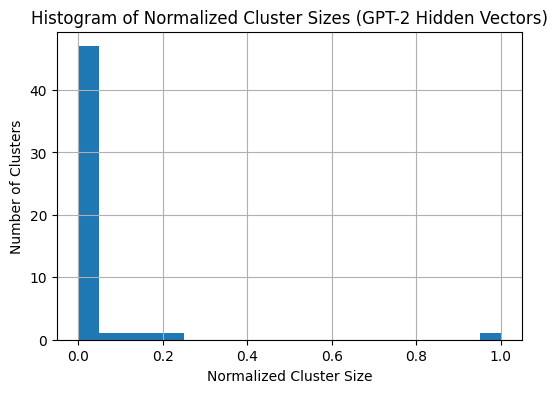

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import linregress

# Histogram binning
bins = np.linspace(0, 1, 21)
hist, bin_edges = np.histogram(normalized_counts, bins=bins)
cluster_bin_counts = hist

# Print histogram info
print("Bins:", bin_edges)
print("Counts per bin:", cluster_bin_counts)

# Plot histogram
plt.figure(figsize=(6, 4))
plt.bar(bin_edges[:-1], cluster_bin_counts, width=0.05, align='edge')
plt.xlabel('Normalized Cluster Size')
plt.ylabel('Number of Clusters')
plt.title('Histogram of Normalized Cluster Sizes (GPT-2 Hidden Vectors)')
plt.grid(True)
plt.show()


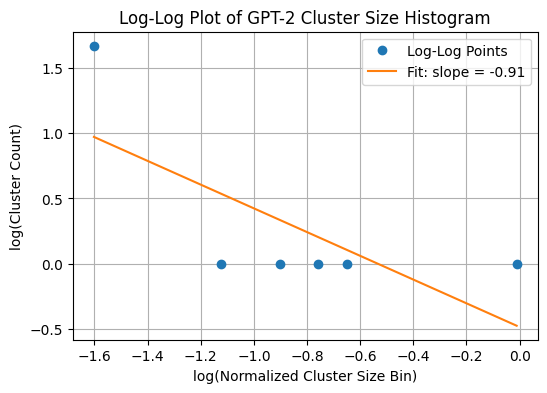

Slope of log-log fit: -0.9110


In [ ]:
# Log-log regression
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
nonzero_mask = cluster_bin_counts > 0
x_vals = bin_centers[nonzero_mask]
y_vals = cluster_bin_counts[nonzero_mask]

log_x = np.log10(x_vals)
log_y = np.log10(y_vals)

slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

# Plot log-log fit
plt.figure(figsize=(6, 4))
plt.plot(log_x, log_y, 'o', label='Log-Log Points')
plt.plot(log_x, slope * log_x + intercept, label=f'Fit: slope = {slope:.2f}')
plt.xlabel('log(Normalized Cluster Size Bin)')
plt.ylabel('log(Cluster Count)')
plt.title('Log-Log Plot of GPT-2 Cluster Size Histogram')
plt.legend()
plt.grid(True)
plt.show()

# Print slope
print(f"Slope of log-log fit: {slope:.4f}")

# Sentence Count distribution plot & Log Log plot


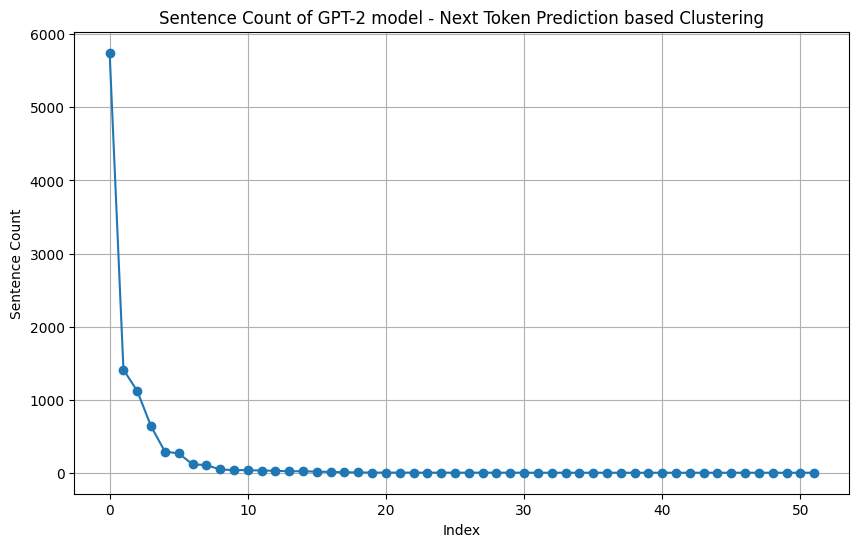

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Plot sentence count distribution
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_counts_desc)), sorted_counts_desc, marker='o')
plt.title("Sentence Count of GPT-2 model - Next Token Prediction based Clustering")
plt.xlabel('Index')
plt.ylabel('Sentence Count')
plt.grid(True)
plt.show()


Regression Results:
   - Slope: -2.5490
   - Intercept: 4.0995
   - R-squared: 0.9669
   - P-value: 1.0966e-38


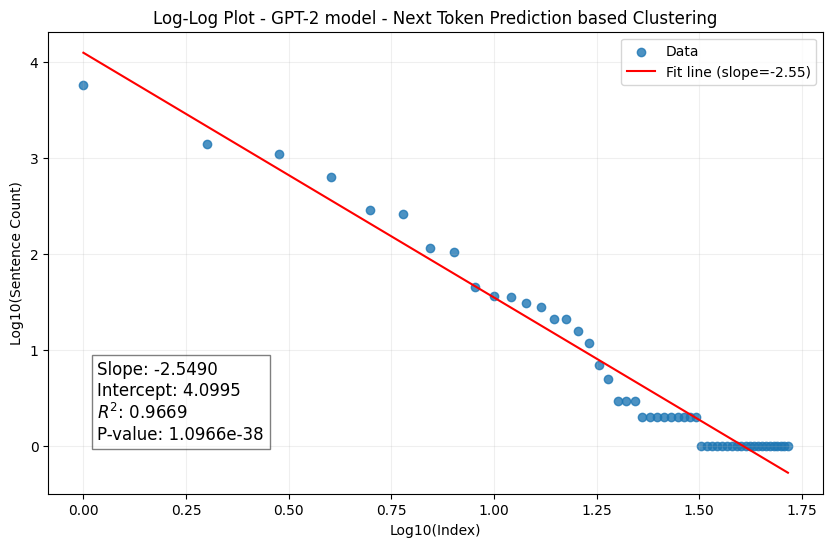

In [ ]:
# Linear regression function
def linear_regression(counts):
    x = np.log10(np.arange(1, len(counts)+1))
    y = np.log10(counts)
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    y_pred = slope * x + intercept
    return x, y, slope, intercept, r_val, p_val, y_pred

# Apply regression
x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(sorted_counts_desc)

# Plot regression line on log-log data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.8, label='Data')
plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')
plt.title("Log-Log Plot - GPT-2 model - Next Token Prediction based Clustering")
plt.xlabel('Log10(Index)')
plt.ylabel('Log10(Sentence Count)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

# Annotate stats
text_x = min(x) + (max(x) - min(x)) * 0.02
text_y = min(y) + (max(y) - min(y)) * 0.02
plt.text(text_x, text_y,
         f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Print to console
print("\nRegression Results:")
print(f"   - Slope: {slope:.4f}")
print(f"   - Intercept: {intercept:.4f}")
print(f"   - R-squared: {r_val**2:.4f}")
print(f"   - P-value: {p_val:.4e}")

plt.show()

# K Means for comparison


In [9]:
final_token_representations = []

batch_size = 32
for i in tqdm(range(0, len(middle_sentences), batch_size), desc="Extracting final token vectors"):
    batch = middle_sentences[i:i+batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")

    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.hidden_states[-1]  # final layer
    last_token_indices = inputs["attention_mask"].sum(dim=1) - 1

    for j in range(len(batch)):
        final_hidden = hidden_states[j, last_token_indices[j], :].cpu().numpy()
        final_token_representations.append(final_hidden)

final_token_representations = np.stack(final_token_representations)  # Shape: [num_sentences, hidden_size]


Extracting final token vectors: 100%|██████████| 313/313 [00:17<00:00, 17.92it/s]


In [10]:
from sklearn.preprocessing import normalize

norm_embeddings = normalize(final_token_representations, axis=1)

plotting


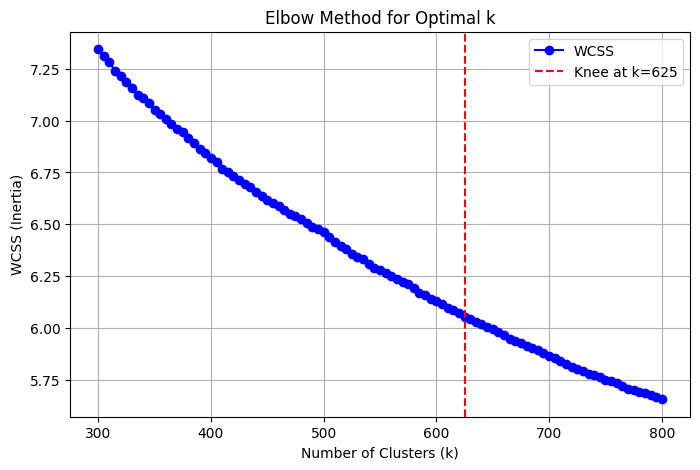

In [29]:
optimal_k = find_optimal_k(norm_embeddings, k_min=300, k_max=800, k_step=5)


In [30]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(norm_embeddings)

print(f"KMeans completed with k = {optimal_k}")

KMeans completed with k = 625


In [31]:
#find the number of points in each clusters. store it into a vector.
from collections import Counter

cluster_counts = Counter(labels)

counts = np.array(list(cluster_counts.values()))


sorted_counts_desc = np.sort(counts)[::-1]

print("sentence counts sorted: ", sorted_counts_desc)

sentence counts sorted:  [44 44 43 43 42 42 42 41 41 40 40 40 39 38 38 37 37 37 37 37 36 36 36 36
 35 35 35 35 35 34 34 34 34 33 33 33 33 33 33 33 33 33 32 32 32 32 32 32
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 30 30 30 30 30 30 30 30 30
 29 29 29 29 29 29 29 29 28 28 28 28 28 28 28 28 28 28 28 28 28 28 27 27
 27 27 27 27 27 27 27 27 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 23 23 23 23 23 23 23 23 23 23 23 23 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 15 15
 15 15 15 15 15 15 15 15 1

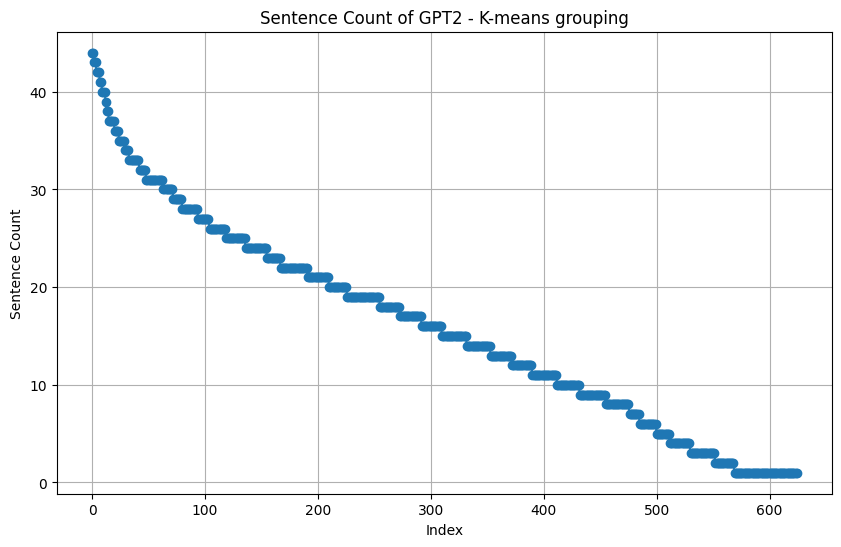

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Plot sentence count distribution
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_counts_desc)), sorted_counts_desc, marker='o')
plt.title("Sentence Count of GPT2 - K-means grouping")
plt.xlabel('Index')
plt.ylabel('Sentence Count')
plt.grid(True)
plt.show()


Regression Results:
   - Slope: -0.7523
   - Intercept: 2.8278
   - R-squared: 0.5170
   - P-value: 1.5478e-100


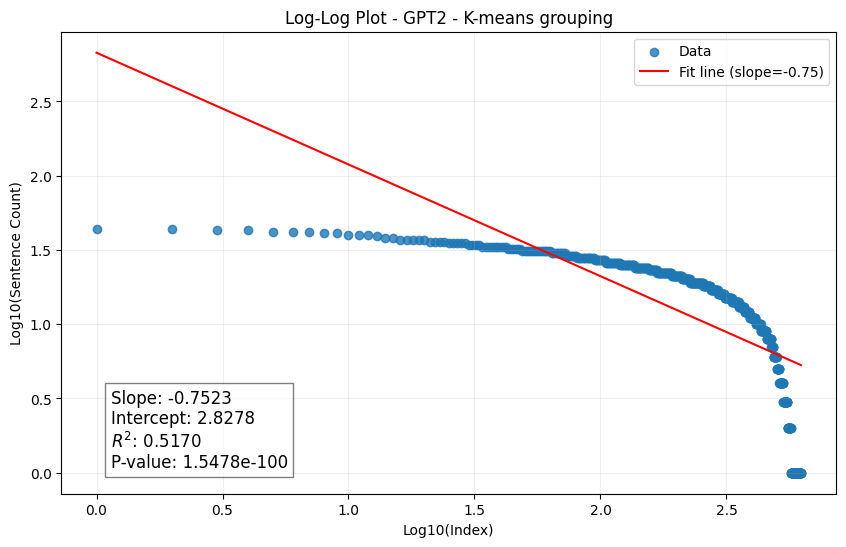

In [33]:
# Linear regression function
def linear_regression(counts):
    x = np.log10(np.arange(1, len(counts)+1))
    y = np.log10(counts)
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    y_pred = slope * x + intercept
    return x, y, slope, intercept, r_val, p_val, y_pred

# Apply regression
x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(sorted_counts_desc)

# Plot regression line on log-log data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.8, label='Data')
plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')
plt.title("Log-Log Plot - GPT2 - K-means grouping")
plt.xlabel('Log10(Index)')
plt.ylabel('Log10(Sentence Count)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

# Annotate stats
text_x = min(x) + (max(x) - min(x)) * 0.02
text_y = min(y) + (max(y) - min(y)) * 0.02
plt.text(text_x, text_y,
         f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Print to console
print("\nRegression Results:")
print(f"   - Slope: {slope:.4f}")
print(f"   - Intercept: {intercept:.4f}")
print(f"   - R-squared: {r_val**2:.4f}")
print(f"   - P-value: {p_val:.4e}")

plt.show()